In [1]:
import numpy as np
import cv2
import pathlib
import os
from scipy.linalg import null_space
import sympy
import time
import numba

class Camera:
    
    def __init__(self, val):
        self.img_num = val # カメラ番号（int;コンストラクタ）
        
        f = 8000/3
        cx = 1920/2
        cy = 1080/2
        A = np.zeros((3,3))
        A[0,0] = f
        A[0,2] = cx
        A[1,1] = f
        A[1,2] = cy
        A[2,2] = 1
        
        self.A = A # 内部パラメータ(ndarray)後から更新

    def img_load(self):
        folder_path = "image"
        file_path = os.path.join(folder_path, str(self.img_num) + ".png")
        img = cv2.imread(file_path, 1)# BGRで読み込み
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.flip(img, 1)
        self.img = img # 画像(ndarray)
        
    def contour_extraction(self):
        
        color_arr = np.array([[255,0,0],[0,255,0],[0,0,255],
                             [255,255,0],[255,0,255],[0,255,255],
                             [127,127,127],[127,0,127],[0,127,127]],dtype = np.int16)
        masks = np.ones((self.img.shape[0], self.img.shape[1], len(color_arr)), dtype=np.uint8)
        
        for i, color in enumerate(color_arr):
            lower = np.clip(color, 0, 255)
            upper = np.clip(color, 0, 255)
            img_mask = cv2.inRange(self.img, lower, upper)
            masks[:,:,i] = img_mask
        
        contour_list = []

        # 色ごとに輪郭（閉曲線）を抽出
        for i in range(masks.shape[2]):
            contours, hierarchy = cv2.findContours(masks[:,:,i],cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
            contour_list += contours
        self.contour_list = contour_list # 輪郭のリスト(list,ndarray)

    def para_load(self):

        folder_path = pathlib.Path("view_mat")
        file_path = os.path.join(folder_path, str(self.img_num)+".csv")
        self.Rt = np.loadtxt(file_path, delimiter="\t")
        self.P = np.dot(self.A, self.Rt[0:3,0:4])
        self.cam_world_cood = -np.dot(self.Rt[0:3,0:3].T, self.Rt[0:3,3])

In [2]:
# 曲線分割
def split_list(contour_length, max_frag_len=100, min_frag_len=40, min_overrap=15):
    
    # 輪郭のフラグメントの位置を指定(最小40 pixl)
    if contour_length > max_frag_len:
        pass
    
    elif contour_length < min_frag_len:
        return None
    
    elif contour_length == min_frag_len:
        return [[0,min_frag_len-1]]
    
    else:
        max_frag_len = contour_length
    
    step0 = np.random.randint(min_frag_len, max_frag_len) # 一つ目のフラグメントの長さ（40から100）
    sep_list = [[0,step0]]
    back = np.random.randint(min_overrap, step0-1) # フラグメントを重ねるために戻す分を決める（最小10 pixl）
    next_start = step0 - back
    
    while True:
        
        # 戻った分(back)より進む
        if back+1 > min_frag_len:
            step = np.random.randint(back+1, max_frag_len)
        else:
            step = np.random.randint(min_frag_len, max_frag_len)

        full_length = next_start + step
        sept = [next_start, full_length]
        sep_list.append(sept)
        back = np.random.randint(10, step-1)
        next_start = full_length - back

        # 終了判定
        if full_length > contour_length:
            break
    
    # 超過した分戻す（長さはそのまま）
    difference = sep_list[-1][1] - (contour_length-1)
    sep_list[-1][0] -= difference
    sep_list[-1][1] -= difference
    
    return sep_list


def contours_split(contour):
    
    #contour.shape = (N, 2)
    contour_length = contour.shape[0]
    sp_list = split_list(contour_length)
    
    if sp_list == None:
        return None
    
    frag_list = []
    # 位置のリスト通りにスライス
    for sp in sp_list:
        #print(sp)
        frag_list.append(contour[sp[0]:sp[1],:])

    return frag_list


def all_fraged(contours_list):
    
    # 輪郭のリストからフラグメントのリストを得る
    frags = []
    for j in contours_list:
        temp_frags = contours_split(j.squeeze())
            
        if temp_frags != None:
            frags += temp_frags
    
    return frags

In [3]:
# camera対応
def dim3_distance(vec1, vec2):
    return sum((vec1-vec2)**2)

def camera_correspondence(cam_list):
    vec_list = []
    for i,cam in enumerate(cam_list):
        vec_list.append(cam_list[i].cam_world_cood)
    pair_list = []
    for i, vec1 in enumerate(vec_list):
        for j, vec2 in enumerate(vec_list):
            if i == j or i > j :
                continue
            elif dim3_distance(vec1,vec2) < 0.65:
                pair_list.append((i,j))
    
    return pair_list

def cam_pos_mean(cam_list):
    _cam_pos = np.zeros(3)
    for cam in cam_list:
        _cam_pos += cam.cam_world_cood
    cam_mean = _cam_pos/len(cam_list)
    return cam_mean

def vec_L2(vec):
    return np.sum(vec**2)**(1/2)

def cal_angle(cam_pos1, cam_pos2, cam_mean):
    vec1 = cam_pos1-cam_mean
    vec2 = cam_pos2-cam_mean
    cossin = np.dot(vec1, vec2)/(vec_L2(vec1)*vec_L2(vec2))
    angle = np.arccos(cossin)
    return angle

def cal_angle_all(cam_list):
    pair_list = []
    cam_mean = cam_pos_mean(cam_list)
    for i, cam1 in enumerate(cam_list):
        for j, cam2 in enumerate(cam_list):
            if i == j or i > j:
                continue
            cam1_pos = cam1.cam_world_cood
            cam2_pos = cam2.cam_world_cood
            angle = cal_angle(cam1_pos, cam2_pos, cam_mean)
            if angle < 1/9*np.pi:
                pair_list.append((i,j))
    return pair_list

In [4]:
# epipole取得

def SS_mat(vec3):
    vec3 = np.squeeze(vec3)
    SS_mat = np.zeros((3, 3))
    SS_mat[0,1] = -vec3[2]
    SS_mat[0,2] = vec3[1]
    SS_mat[1,0] = vec3[2]
    SS_mat[1,2] = -vec3[0]
    SS_mat[2,0] = -vec3[1]
    SS_mat[2,1] = vec3[0]
    return SS_mat

def FF_mat(A1, A2, Rt1, Rt2):
    P1 = np.dot(A1, Rt1[0:3,0:4])
    P2 = np.dot(A2, Rt2[0:3,0:4])
    cam_pos1 = -np.dot(Rt1[0:3,0:3].T, Rt1[0:3,3])
    cam_pos1 = np.array([cam_pos1[0], cam_pos1[1], cam_pos1[2], 1])
    epipole2 = np.dot(P2, cam_pos1)
    cam_pos2 = -np.dot(Rt2[0:3,0:3].T, Rt2[0:3,3])
    cam_pos2 = np.array([cam_pos2[0], cam_pos2[1], cam_pos2[2], 1])
    epipole1 = np.dot(P1, cam_pos2)
    return epipole1, epipole2, np.dot(SS_mat(epipole2), np.dot(P2, np.linalg.pinv(P1)))

In [5]:
def normalization(vec3):
    return vec3[0]/vec3[2], vec3[1]/vec3[2]

In [6]:
# 再構築
def nom_F(F):
    return (1/sum(sum(F**2))**(1/2))*F

def cover_mat(x1, y1, x2, y2):
    return np.array([[x1**2+x2**2, x2*y2, x2, x1*y1, 0, 0, x1, 0, 0],
                    [x2*y2, x1**2+y2**2, y2, 0, x1*y1, 0, 0, x1, 0],
                    [x2, y2, 1, 0, 0, 0, 0, 0, 0],
                    [x1*y1, 0, 0, y1**2+x2**2, x2*y2, x2, y1, 0, 0],
                    [0, x1*y1, 0, x2*y2, y1**2+y2**2, y2, 0, y1, 0],
                    [0, 0, 0, x2, y2, 1, 0, 0, 0],
                    [x1, 0, 0, y1, 0, 0, 1, 0, 0],
                    [0, x1, 0, 0, y1, 0, 0, 1, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]])

def min_dist(F, pt1, pt2):# pt1が画像2上の点，pt2が画像1上の点
    S0 = 10**10
    x1_ori = pt1[0]
    y1_ori = pt1[1]
    x2_ori = pt2[0]
    y2_ori = pt2[1]
    
    x1 = pt1[0]
    y1 = pt1[1]
    x2 = pt2[0]
    y2 = pt2[1]
    
    x1_tilda = 0
    y1_tilda = 0
    x2_tilda = 0
    y2_tilda = 0
    thita = nom_F(F).flatten()
    it = 0
    while True:
        V_eps = cover_mat(x1, y1, x2, y2)
        eps_ast = np.array([x1*x2 + x2*x1_tilda + x2*x2_tilda,
                           x1*y2 + y2*x1_tilda + x2*y2_tilda,
                           x1 + x1_tilda,
                           y1*x2 + x2*y1_tilda + y1 * x2_tilda,
                           y1* y2 + y2*y1_tilda + y1*y2_tilda,
                           y1 + y1_tilda,
                           x2 + x2_tilda,
                           y2 + y2_tilda,
                           1])
        
        x1_y1_tilda = np.dot(eps_ast, thita) * np.dot(np.array([[thita[0], thita[1], thita[2]], [thita[3], thita[4], thita[5]]]), np.array([x2, y2, 1])) / np.dot(thita, np.dot(V_eps, thita))
        x2_y2_tilda = np.dot(eps_ast, thita) * np.dot(np.array([[thita[0], thita[3], thita[6]], [thita[1], thita[4], thita[7]]]), np.array([x1, y1, 1])) / np.dot(thita, np.dot(V_eps, thita))
        
        x1_tilda = x1_y1_tilda[0]
        y1_tilda = x1_y1_tilda[1]
        x2_tilda = x2_y2_tilda[0]
        y2_tilda = x2_y2_tilda[1]
        
        x1 = x1_ori - x1_tilda
        y1 = y1_ori - y1_tilda
        x2 = x2_ori - x2_tilda
        y2 = y2_ori - y2_tilda
        
        S = x1_tilda**2 + y1_tilda**2 + x2_tilda**2 + y2_tilda**2
        
        if abs(S0 - S) < 0.00001:
            break

        elif it == 20:
            break

        else:
            S0 = S
            it += 1

    return np.array((x1, y1)), np.array((x2, y2))

def Ps(P, pt):
    a = P[0,0] - pt[0]*P[2,0]
    b = P[0,1] - pt[0]*P[2,1]
    c = P[0,2] - pt[0]*P[2,2]
    d = P[0,3]
    e = pt[0]*P[2,3]
    f = P[1,0] - pt[1]*P[2,0]
    g = P[1,1] - pt[1]*P[2,1]
    h = P[1,2] - pt[1]*P[2,2]
    i = P[1,3]
    j = pt[1]*P[2,3]
    return a, b, c, d, e, f, g, h, i, j

def tri(P1, P2, pt1, pt2):
    a1, b1, c1, d1, e1, f1, g1, h1, i1, j1 = Ps(P1, pt1)
    a2, b2, c2, d2, e2, f2, g2, h2, i2, j2 = Ps(P2, pt2)
    T = np.array([[a1, b1, c1],
                 [f1, g1, h1],
                 [a2, b2, c2],
                 [f2, g2, h2]])
    p = np.array([[d1-e1],
                 [i1-j1],
                 [d2-e2],
                 [i2-j2]])
    T_inv = np.linalg.pinv(T)
    result_pt = np.dot(T_inv, -p)
    return result_pt

In [7]:
import matplotlib.pyplot as plt

In [62]:
cam_list = [Camera(i) for i in range(0,48)]
for i in range(len(cam_list)):
    cam_list[i-1].img_load()
    cam_list[i-1].contour_extraction()
    cam_list[i-1].para_load()

In [9]:
# エピポール取得
#cam_pairs = cal_angle_all(cam_list)
cam_pairs = cal_angle_all(cam_list)

epipole_list = np.zeros((int(len(cam_pairs)*2),2))
epipole_list_idx = np.zeros(int(len(cam_pairs)*2))
F_pair_list = [] # Fに対応するpair
cam_pairs_F_array = []

for num, i in enumerate(cam_pairs):
    epipole1, epipole2, F = FF_mat(cam_list[i[0]].A, cam_list[i[1]].A, cam_list[i[0]].Rt, cam_list[i[1]].Rt)
    epipole_list[int(num*2)] = normalization(epipole1)
    epipole_list_idx[int(num*2)] = i[0]
    epipole_list[int(num*2)+1] = normalization(epipole2)
    epipole_list_idx[int(num*2)+1] = i[1]
    F_pair_list.append(i)
    cam_pairs_F_array.append(F)
cam_pairs_F_array = np.array(cam_pairs_F_array) # Fが入ったarray


In [10]:
#エピポールと輪郭上の点を結んだ直線と，x軸のなす角
def gene(angles):
    # 正規化
    B = list(map(lambda y:y-min(angles),angles))
    return list(map(lambda y: (y-min(B))/(max(B)-min(B)), B))

def epipole_angle(img_num, epipole_list, epipole_list_idx):
    cam = cam_list[img_num]
    angle_list = []
    
    epipole_img_num_idx = np.where(epipole_list_idx == img_num)
    epipole_img_num = epipole_list[epipole_img_num_idx]
    for epi in epipole_img_num:
        epi_angle_list = []
        for contour in cam.contour_list:
            pre_tilt = contour - epi
            pre_tilt = pre_tilt.reshape([-1,2])
            tilt = pre_tilt[:,1]/pre_tilt[:,0]
            angle = np.arctan(tilt)
            angle = gene(angle)
            epi_angle_list.append(angle)
        angle_list.append(epi_angle_list)
        
    return angle_list

def differential(angles):
    # エピポーラ線に平行な接線をもつ点(前後方微分の正負を比べたほうが良い)
    del_idx = []
    for i in range(len(angles)):
        if np.isnan(angles[i]):
            continue
        if i == len(angles)-1:
            if np.sign(angles[i]-angles[i-1]) != np.sign(angles[0]-angles[i]) or abs(angles[0]-angles[i-1])/2 < 0.001:
                del_idx.append(i)
        else:
            if np.sign(angles[i]-angles[i-1]) != np.sign(angles[i+1]-angles[i])or abs(angles[i+1]-angles[i-1])/2 < 0.001:
                del_idx.append(i)
    return del_idx

def marge_del(all_del_list):
    marged = []
    for j in range(len(all_del_list[0])):
        stem = []
        for i in range(len(all_del_list)):
            stem += all_del_list[i][j]
        marged.append(list(set(stem)))
    return marged

def all_D(angles_list):
    # 画像1枚に対して削除リストを作成
    all_del_list = []
    for epi in angles_list:
        epi_del_list = []
        for contour in epi:
            del_idx = differential(contour)
            epi_del_list.append(del_idx)
        all_del_list.append(epi_del_list)
    marged = marge_del(all_del_list)
    return marged

In [11]:
# エピポーラ線との接線で分割
def separate(contour, del_idx):
    # 一つの輪郭に対し削除リストから削除
    start = 0
    newArray = []
    for d in del_idx:
        if contour[start:d] != []:
            if contour[start:d].size != 0:
                newArray.append(contour[start:d])
        start = d+1

    if contour[start:].size != 0:
        newArray.append(contour[start:])
    return newArray

def all_sep(con_list, del_list):
    n_list = []
    for con, del_con in zip(con_list, del_list) :
        n_con = separate(con, del_con)
        if len(n_con) != 0:
            for i in n_con:
                n_list.append(i)
    return n_list

In [12]:
def frag_max_len(frag_list):
    max_len = 0

    for i in frag_list:
        a = len(i)
        if a > max_len:
            max_len = a
    return max_len

def trim_frag_list(frag_list):
    max_len = frag_max_len(frag_list)
    np_frag_list = np.empty([len(frag_list), 100, 2])
    np_frag_list[:,:] = np.nan
    for i, frag in enumerate(frag_list):
        np_frag_list[i, 0:len(frag),] = np.array(frag)
    return np_frag_list

def trim_all_frag():
    for i in range(len(cam_list)):
        _frag_list = cam_list[i].frag_list
        np_frag_list = trim_frag_list(_frag_list)
        cam_list[i].frag_list = np_frag_list

In [13]:
# フラグメントのリストを作る
for i in range(len(cam_list)):
    #im_del_list = all_D(epipole_angle(i, epipole_list, epipole_list_idx))# im_del_list[color][contour][del_idx]
    #newCon = all_sep(cam_list[i].contour_list, im_del_list)# newCon[color][fragment][coordination]
    cam_list[i].frag_list = all_fraged(cam_list[i].contour_list)#newCon)
trim_all_frag()

In [14]:
# マスク，パラメータの読み込みはoverrideで書く
#
# ここまでの処理でできたもの
# cam_list
# cam_list[i].frag_list 長さは100固定
# その他カメラ位置，パラメータ
#
# cam_pairs_F_array
# F_pair_list
# ペアに対するF行列

In [15]:
cnum = 4
new_img = np.zeros((cam_list[0].img.shape[0],cam_list[0].img.shape[1]),dtype=np.bool8)

for j in range(len(cam_list[cnum].frag_list)):
    curve = cam_list[cnum].frag_list[j][~np.isnan(cam_list[cnum].frag_list[j])].reshape((-1,2)).astype(int)
    new_img[curve[:,1],curve[:,0]]=True

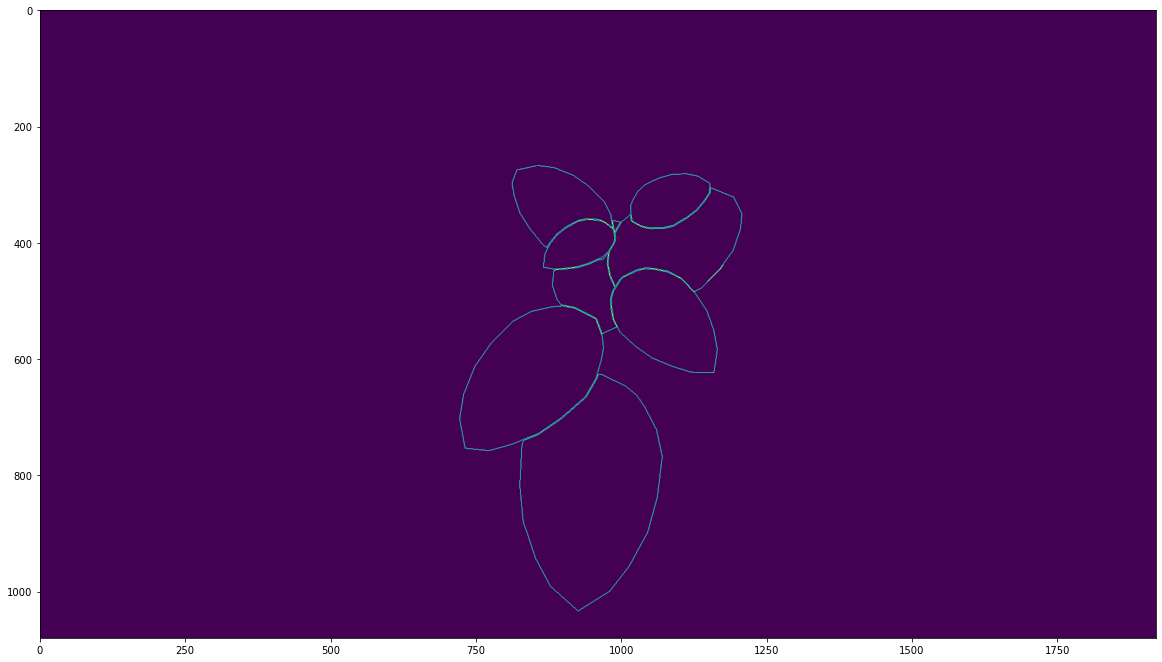

In [16]:
%matplotlib inline
fig = plt.figure(figsize = (20, 20))
fig.patch.set_alpha(0.)
# 3DAxesを追加
ax = fig.add_subplot(111)
plt.imshow(new_img)

In [17]:
# エピポーラ関係
def epilines_para(frags, F):
    lines_list = []
    for frag in frags:
        frag_lines = cv2.computeCorrespondEpilines(frag.reshape(-1,1,2), 1,F) # ndarray(フラグメントの座標数,1,3)
        lines_list.append(frag_lines)
    return lines_list

In [18]:
# 衝突判定

# epilines_paraで作ったパラメータからエピラインの先端と終端を計算する
def para2cood_S(para_list):
    cood_S = []
    for a,b,c in para_list:
        if np.isnan(a):
            cood_S.append(np.array([np.nan, np.nan]))
        else:
            cood_S.append(np.array([0, -c/b]))
    return cood_S

def para2cood_F(para_list):
    cood_F = []
    for a,b,c in para_list:
        if np.isnan(a):
            cood_F.append(np.array([np.nan, np.nan]))
        else:
            cood_F.append(np.array([1920, -(1920*a+c)/b]))# 画像の横の大きさ
    return cood_F

def all_pa2co(para_list):
    epi_cood_S = []
    epi_cood_F = []
    for frag in para_list:
        S_cood = para2cood_S(frag.squeeze())
        F_cood = para2cood_F(frag.squeeze())
        epi_cood_S.append(S_cood)
        epi_cood_F.append(F_cood)
    return np.array(epi_cood_S), np.array(epi_cood_F) # epi_cood[frag]

# fragmentの先端と終端を得る
def get_frag_cood(frag_list):
    cood_S = np.array([frag[0] for frag in frag_list])
    cood_F = []
    for frag in frag_list:
        frag = frag[~np.isnan(frag)]# 一度平坦化している
        cood_F.append((frag[-2],frag[-1]))
    cood_F = np.array(cood_F)
    return cood_S, cood_F # cood_S[frag]

# 外積計算，ここのbroadcastが重い
def coll_t1_t2(epi_cood_S, epi_cood_F, cood_S, cood_F):
    #epi_cood_S_bro = np.array([np.broadcast_to(aa, (len(cood_S), 2)) for aa in epi_cood_S])
    #epi_cood_F_bro = np.array([np.broadcast_to(aa, (len(cood_S), 2)) for aa in epi_cood_F])
    
    epi_cood_S_bro = np.repeat(epi_cood_S,len(cood_S),axis=0).reshape((epi_cood_S.shape[0],len(cood_S),epi_cood_S.shape[1]))
    epi_cood_F_bro = np.repeat(epi_cood_F,len(cood_S),axis=0).reshape((epi_cood_F.shape[0],len(cood_S),epi_cood_F.shape[1]))
    
    v = cood_S - epi_cood_S_bro
    v2 = cood_F - cood_S
    v1 = epi_cood_F_bro - epi_cood_S_bro
    t1 = np.cross(v, v2)/np.cross(v1, v2)
    t2 = np.cross(v, v1)/np.cross(v1, v2)
    return t1, t2

# 衝突判定
def coll_det(t1, t2):
    t1_t = np.array((t1 <= 1) & (t1 > 0),dtype=np.int16)
    t2_t = np.array((t2 <= 1) & (t2 > 0),dtype=np.int16)
    count_c = np.array(t1_t + t2_t == 2, dtype=np.int64)
    surport_idx = np.argmax(np.sum(count_c,axis=0))
    return surport_idx

def make_pair_list(epi_cood_S, epi_cood_F, cood_S, cood_F):
    img_list=[]
    for epi_frag_S, epi_frag_F in zip(epi_cood_S, epi_cood_F):
        t1, t2 = coll_t1_t2(epi_frag_S, epi_frag_F, cood_S, cood_F)
        surport_idx = coll_det(t1, t2)
        img_list.append(surport_idx)
    return img_list

def pair_and_key_gen(F, pair):
    frags_para12 = epilines_para(cam_list[pair[0]].frag_list, F) # frags_para[色][frag]
    frags_para21 = epilines_para(cam_list[pair[1]].frag_list, F.T)
    if cam_list[pair[0]].frag_list.size == 0 or cam_list[pair[1]].frag_list.size == 0:
        return None
    cood_S, cood_F = get_frag_cood(cam_list[pair[1]].frag_list)
    epi_cood_S, epi_cood_F = all_pa2co(frags_para12)
    img_list1 = make_pair_list(epi_cood_S, epi_cood_F, cood_S, cood_F)

    cood_S, cood_F = get_frag_cood(cam_list[pair[0]].frag_list)
    epi_cood_S, epi_cood_F = all_pa2co(frags_para21)
    img_list2 = make_pair_list(epi_cood_S, epi_cood_F, cood_S, cood_F)

    #pair_list.append(img_list1)
    #pair_list.append(img_list2)
    #key_list.append(((pair[0],pair[1]), "F"))
    #key_list.append(((pair[0],pair[1]), "R"))
    return img_list1, ((pair[0],pair[1]), "F"), img_list2, ((pair[0],pair[1]), "R")

def wrapper_pair_and_key_gen(args):
    return pair_and_key_gen(*args)

In [19]:
%%time
import joblib
wrap = [[F, pair] for F, pair in zip(cam_pairs_F_array, F_pair_list)]
result = joblib.Parallel(n_jobs=-1)(joblib.delayed(wrapper_pair_and_key_gen)(i) for i in wrap)

# 直線のパラメータから座標にするとき桁が大きくなりすぎてエラーを吐くことがある（para2cood）

Wall time: 139 ms


In [20]:
# 並列化していない方 Wall time: 13min 28s
#%%time
#pair_list = []
#key_list = []
#for F, pair in zip(cam_pairs_F_array, F_pair_list):
#    A = pair_and_key_gen(F, pair)
#    pair_list.append(A[0])
#    pair_list.append(A[2])
#    key_list.append(A[1])
#    key_list.append(A[3])

# 直線のパラメータから座標にするとき桁が大きくなりすぎてエラーを吐くことがある（para2cood）

In [21]:
pair_list = []
key_list = []
for i in result:
    if i == None:
        continue
    pair_F, key_F, pair_R, key_R =i
    pair_list.append(pair_F)
    pair_list.append(pair_R)
    key_list.append(key_F)
    key_list.append(key_R)

In [22]:
# pair_list 長さ：フラグメント数　数値：相手のフラグメントのidx
# ((0,2),"F")ならidxがimage0のフラグメントidx，数値がimage2のフラグメントidx
# key_list pair_listに対応してkeyが入っている

In [23]:
# マージ関連
def cam_graph(pair_list, key_list, cam_list_length):
    keys_graph = []

    for main_key in range(cam_list_length):
        temp_graph = []

        for sub_key in key_list:
            sub_key_num_1 = sub_key[0][0]
            sub_key_num_2 = sub_key[0][1]
            if sub_key_num_1 == main_key and sub_key_num_2 not in temp_graph:
                temp_graph.append(sub_key_num_2)
            elif sub_key_num_2 == main_key and sub_key_num_1 not in temp_graph:
                temp_graph.append(sub_key_num_1)
        keys_graph.append(temp_graph)
    return keys_graph

# 固定の深さまでを返す
def DFS(graph, start, depth, mark_list):
    if start not in mark_list:
        mark_list.append(start)
    #depth -= 1
    if depth == 0:
        pass
    
    elif depth != 0:
        depth -= 1
        for target in graph[start]:
            if target not in mark_list:
                mark_list.append(target)
                #print(mark_list)
                DFS(graph, target, depth, mark_list)
    return mark_list

def make_key_set(pair_list, key_list, cam_list_length):
    keys_graph = cam_graph(pair_list, key_list, cam_list_length)
    set_key_list = []
    for idx in range(cam_list_length):
        
        dfs = DFS(keys_graph, idx, 4, [])
        sets = key_set_part(dfs, key_list)
        set_key_list.append(sets)
    return set_key_list

def key_set_part(dfs, keys):
    l = []
    for i in keys:
        for j in dfs:
            if j in i[0]:
                l.append(i)
    return set(l)

In [24]:
# マージ関連
def organize_keys(graph_part, ini, mark_list): 
    stem = []
    for key in graph_part:
        if ini == key[0][0] and key[1] == "F":
            stem.append(key)
            mark_list.append(key[0])
        elif ini == key[0][1] and key[1] == "R":
            stem.append(key)
            mark_list.append(key[0])
            
    key_l = []
    for i in stem:
        if ini == i[0][0]:
            idx = i[0][1]
        elif ini == i[0][1]:
            idx = i[0][0]
        l = organize_keys_sub(graph_part, idx, mark_list,[])
        _key_l = [i]+l
        key_l.append(_key_l)
    return key_l

def organize_keys_sub(graph_part, idx, mark_list, l):
    for key in graph_part:
        if idx in key[0]:
            
            if idx == key[0][0] and key[1] == "F" and key[0] not in mark_list:
                idx = key[0][1]
                mark_list.append(key[0])
                l.append(key)
                organize_keys_sub(graph_part,idx,mark_list,l)
            
            elif idx == key[0][1] and key[1] == "R" and key[0] not in mark_list:
                idx = key[0][0]
                mark_list.append(key[0])
                l.append(key)
                organize_keys_sub(graph_part,idx,mark_list,l)
    return l

def all_organize_keys(keys):
    o_keys=[]
    for idx, g_part in enumerate(keys):
        o_keys.append(organize_keys(g_part, idx, []))
    return o_keys

In [25]:
# マージ関連
def interpret_o_key_part(tag_list):
    curve_pair_list = []
    init_pair = np.array(pair_list[key_list.index(tag_list[0])])
    idx_pair = init_pair
    curve_pair_list.append(idx_pair)
    for i, tag in enumerate(tag_list):
        if i == 0:
            continue
        idx_pair = np.array(pair_list[key_list.index(tag)])[idx_pair]
        curve_pair_list.append(idx_pair)
    return np.array(curve_pair_list)

def interpret_o_key_part2(tag_list_list):
    c_pair = []
    for i in tag_list_list:
         c_pair.append(interpret_o_key_part(i))
    return np.array(c_pair)

def interpret_o_key(tag_list_list_list):
    c_pair = []
    for i in tag_list_list_list:
        c_pair.append(interpret_o_key_part2(i))
    return c_pair

In [26]:
#s = make_key_set(pair_list, key_list, len(cam_list))
#o_keys = all_organize_keys(s)
#inted_o_key = interpret_o_key(o_keys)

In [27]:
def FR_cheacker(key, pair_list, cam_list):
    F = cam_pairs_F_array[F_pair_list.index(key[0])]
    if key[1] == "F":
        frags_para = epilines_para(cam_list[key[0][0]].frag_list, F) # frags_para[色][frag]
        epi_cood_S, epi_cood_F = all_pa2co(frags_para)
        camL_idx = key[0][1]
    elif key[1] == "R":
        frags_para = epilines_para(cam_list[key[0][1]].frag_list, F.T)
        epi_cood_S, epi_cood_F = all_pa2co(frags_para)
        camL_idx = key[0][0]
    return epi_cood_S, epi_cood_F, camL_idx

In [28]:
# 線と点の衝突判定
def PL_coll(key, pair_list, cam_list):
    epi_cood_S, epi_cood_F, camL_idx = FR_cheacker(key, pair_list, cam_list)
    frag_part = cam_list[camL_idx].frag_list
    im_list = []
    for pair_frag, epi_S_frag, epi_F_frag in zip(pair_list[key_list.index(key)], epi_cood_S, epi_cood_F):
        pts = frag_part[pair_frag] # 対応するフラグメント
        v1 = epi_F_frag - epi_S_frag
        v1_n = (v1[:,0]**2+v1[:,1]**2)**(1/2)
        v1_n = np.stack([v1_n, v1_n], axis=1)
        v1 = v1/v1_n
        #v1_bro = np.array([np.broadcast_to(aa, (len(pts), 2)) for aa in v1])
        #epi_cood_S_bro = np.array([np.broadcast_to(aa, (len(pts), 2)) for aa in epi_S_frag])
        
        v1_bro = np.repeat(v1,len(pts),axis=0).reshape((v1.shape[0],len(pts),v1.shape[1]))
        epi_cood_S_bro = np.repeat(epi_S_frag,len(pts),axis=0).reshape((epi_S_frag.shape[0],len(pts),epi_S_frag.shape[1]))
        
        v2 = pts - epi_cood_S_bro
        v2_n = (v2[:,:,0]**2+v2[:,:,1]**2)**(1/2)
        v2_n = np.stack([v2_n, v2_n], axis=2)
        v2 = v2/v2_n
        con_det = np.cross(v1_bro, v2)
        im_list.append(np.where(np.abs(con_det) <= 0.001))
    return im_list

In [29]:
%%time
# Wall time: 2min 8s
# 点と線の衝突判定
coll_list = []
for key in key_list:
    im_list = PL_coll(key, pair_list, cam_list)
    coll_list.append(im_list)

Wall time: 0 ns


In [30]:
# coll_list[key][frag][idx]
# keyが((0,2),"F")に当たるなら0から2に対してエピポーラ線を飛ばしたときの衝突判定

In [31]:
# 対応点候補から対応点を作る
def pt_pair(coll_list):
    pool_i = []
    pool_j = []
    pre_i = None
    pre_j = None
    pt = 1
    for i, j in zip(coll_list[0], coll_list[1]):
        if i in pool_i:
            if pt == 1:
                continue
            elif pt == 0:
                if j not in pool_j:
                    pool_i.pop()
                    pool_j.pop()
                    pool_i.append(i)
                    pool_j.append(j)
                else:
                    continue

        elif i not in pool_i:
            if j in pool_j:
                pt = 0
            else:
                pt = 1
            pool_i.append(i)
            pool_j.append(j)
    return np.array([pool_i, pool_j])

In [32]:
%%time
# 点の一対一対応
pair_pt = []
for i in range(len(key_list)):
    im_list = []
    for frag in coll_list[i]:
        newPair = pt_pair(frag)
        im_list.append(newPair)
    pair_pt.append(im_list)

Wall time: 0 ns


In [33]:
# pair_pt[key][frag][idx]
# coll_listのダブりをなくした

In [34]:
# クォーテーション部分はマージ関連

In [35]:
#pre_test_list = []
#new_inted_o_key = np.concatenate([np.arange(inted_o_key[0][0].shape[1]).reshape(1,-1),inted_o_key[0][0]])
#for row in new_inted_o_key.T:
#    for key, idx in zip(o_keys[0][0], row):
#        print(key, idx)
#        pre_test_list.append(pair_pt[key_list.index(key)][idx])
#        # pre_test_listを上手く処理する関数
#    break

In [36]:
# pre_test_listを上手く処理する関数
#for i, idx in enumerate(pre_test_list):
#    if i == 0:
#        new_test_list = idx
#    else:
#        forward = new_test_list[-1]
#        for j in forward:
#            print(np.where(idx[0] == j))

In [37]:
#"""def pt_correspondence_graph(key, correspondence, pair_pt):
#
#    pair_1 = pair_pt[key[0]]
#    pair_2 = pair_pt[key[1]]
#
#    pt_corr_list = []

#    for cam1_frag_idx, cam2_frag_idx in zip(correspondence[:,0], correspondence[:,1]):
#        cam1_cood_idx, cam2_cood_idx = pair_1[cam1_frag_idx]
#        pre_cam2_cood_idx, pre_cam3_cood_idx = pair_2[cam2_frag_idx]
#        pre_sub_idx = 0
#        cam3_cood_idx = np.zeros(cam2_cood_idx.shape)
#
#        for i, sub_cood_idx in enumerate(cam2_cood_idx):
#            sub_idx = np.where(pre_cam2_cood_idx == sub_cood_idx)
#            if len(sub_idx[0]) > 1:
#                idx_diff = 100
#                for j in sub_idx:
#                    temp_idx_diff = abs(j-pre_sub_idx)
#                    if temp_idx_diff < idx_diff:
#                        sub_idx = j
#                        idx_diff = temp_idx_diff
#
#            elif sub_idx[0].size == 0:
#                sub_idx = None
#
#            else:
#                sub_idx = sub_idx[0][0]
#
#            if sub_idx != None:
#                cam3_cood_idx[i] = pre_cam3_cood_idx[sub_idx]
#            else:
#                cam3_cood_idx[i] = np.nan
#            pre_sub_idx = sub_idx
#        pt_corr = np.array([cam1_cood_idx, cam2_cood_idx, cam3_cood_idx])
#        pt_corr_list.append(pt_corr)
#    return pt_corr_list

#def all_pt_corr_graph(key_order, correspondence_list, pair_pt):
#    main_list = []
#    for main in range(len(key_order)):
#        sub_list = []
#        for sub in range(len(key_order[main])):
#            key = key_order[main][sub]
#            correspondence = correspondence_list[main][sub]
#            pt_corr_list = pt_correspondence_graph(key, correspondence, pair_pt)
#            sub_list.append(pt_corr_list)
#        main_list.append(sub_list)
#    return main_list"""

In [38]:
def FR_frags(key):
    if key[1] == "F":
        part = cam_list[key[0][0]].frag_list
        counterpart = cam_list[key[0][1]].frag_list
        return part, counterpart
        
    elif key[1] == "R":
        part = cam_list[key[0][1]].frag_list
        counterpart = cam_list[key[0][0]].frag_list
        return part, counterpart

In [39]:
# 座標でdictを作る
coordinate_list =[]
nan_idx_list = []
for i, key in enumerate(key_list):
    pair_coordinate = []
    nan_idx_list = []
    part, counterpart = FR_frags(key)
    index = 0
    
    for part_frag, pair, pt_idx in zip(part, pair_list[i], pair_pt[i]):
        if pt_idx[0].size != 0:
            pair_coordinate.append((np.array([part_frag[pt_idx[0]], counterpart[pair][pt_idx[1]]])))
        else:
            nan_idx_list.append(index)
        index += 1
    coordinate_list.append(pair_coordinate)
    nan_idx_list.append(nan_idx_list)

In [40]:
def FR_check(key):
    if key[1] == "F":
        P1 = cam_list[key[0][0]].P
        P2 = cam_list[key[0][1]].P
        F = cam_pairs_F_array[F_pair_list.index(key[0])]
        return P1, P2, F
    
    elif key[1] == "R":
        P1 = cam_list[key[0][1]].P
        P2 = cam_list[key[0][0]].P
        F = cam_pairs_F_array[F_pair_list.index(key[0])]
        return P1, P2, F

In [41]:
def Three_dim_lines_reconst(key_list, coordinate_list):
    
    TDlines = []
    for i, pts in enumerate(coordinate_list):
        P1_ori, P2_ori, F_ori = FR_check(key_list[i])
        temp_TDlines = []
        for pt in pts:
            pt = np.transpose(pt, (1, 0, 2))
            F = np.broadcast_to(F_ori, (pt.shape[0],3,3))
            P1 = np.broadcast_to(P1_ori, (pt.shape[0],3,4))
            P2 = np.broadcast_to(P2_ori, (pt.shape[0],3,4))
            newcoords= np.array(list(map(min_dist, F, pt[:,1,:], pt[:,0,:])))
            tri_pt = np.array(list(map(tri, P1, P2, newcoords[:,1,:], newcoords[:,0,:])))
            #pts_array = sep_array(tri_pt, sep_list)
            temp_TDlines.append(tri_pt)
        TDlines.append(temp_TDlines)
        print((i+1)/len(coordinate_list)*100)
    return TDlines

In [42]:
%%time
TDlines = Three_dim_lines_reconst(key_list, coordinate_list)

Wall time: 0 ns


In [43]:
# 以下

In [44]:
def excluded_Parray(ex_tag):
    P_dict = {}
    for i, cam in enumerate(cam_list):
        if i in ex_tag:
            continue
        P_dict[i] = cam.P
    return P_dict

def dot_P_frag(P, frag):
    repro_frag = []
    for pt in frag:
        repro_pt = np.dot(P, pt)
        repro_pt = np.array(normalization(repro_pt))
        repro_frag.append(repro_pt)
    return np.array(repro_frag)

In [45]:
def get_reprojection_list(key_list, TDlines):
    reprojection_list = []
    reprojection_key = []
    for j, tag in enumerate(key_list):
        temp_reprojection_list = []
        temp_reprojection_key = []
        P_dict = excluded_Parray(tag[0])
        for P_tag in P_dict:
            P = P_dict[P_tag]
            P_list = []
            for i, frag in enumerate(TDlines[j]):
                frag = frag.reshape((-1,3))
                frag = np.concatenate([frag, np.ones(len(frag)).reshape((len(frag), 1))],1) # 末尾に1を追加 (X, Y, Z, 1)
                reprojection = dot_P_frag(P, frag)
                P_list.append(reprojection)
            temp_reprojection_list.append(P_list)
            temp_reprojection_key.append(P_tag)
        reprojection_list.append(temp_reprojection_list)
        reprojection_key.append(temp_reprojection_key)
    return reprojection_list, reprojection_key

In [46]:
#reprojection_list = []
#for j, tag in enumerate(key_list):
#    temp_reprojection_list = []
#    temp_reprojection_key = []
#    P_dict = excluded_Parray(tag[0])
#    for P_tag in P_dict:
#        P = P_dict[P_tag]
#        P_list = []
#        for i, frag in enumerate(TDlines[j]):
#            frag = frag.reshape((-1,3))
#            frag = np.concatenate([frag, np.ones(len(frag)).reshape((len(frag), 1))],1) # 末尾に1を追加 (X, Y, Z, 1)
#            reprojection = dot_P_frag(P, frag)
#            P_list.append(reprojection)
#        temp_reprojection_list.append(P_list)
#        temp_reprojection_key.append(P_tag)
#    reprojection_list.append(temp_reprojection_list)

In [47]:
#reprojection_dict = {}
#for tag in TDlines:
#    temp_reprojection_dict = {}
#    P_dict = excluded_Parray(tag[0])
#    for P_tag in P_dict:
#        P = P_dict[P_tag]
#        P_list = []
#        for i, frag in enumerate(TDlines[tag]):
#            frag = frag.reshape((-1,3))
#            frag = np.concatenate([frag, np.ones(len(frag)).reshape((len(frag), 1))],1) # 末尾に1を追加 (X, Y, Z, 1)
#            reprojection = dot_P_frag(P, frag)
#            P_list.append(reprojection)
#        temp_reprojection_dict[P_tag] = P_list
#    reprojection_dict[tag] = temp_reprojection_dict

In [48]:
%%time
reprojection_list, reprojection_key = get_reprojection_list(key_list, TDlines)

Wall time: 0 ns


In [49]:
def connect_contour(contour_list):
    A = np.concatenate(contour_list).reshape((-1, 2))
    return A

In [50]:
def curve_contour_correspondence(dis):
    contours_count_list = np.sum(np.where((dis<10),1,0),axis=0)
    contours_count_list_idx = np.where(contours_count_list > 0)
    _, gap_idx = np.where(np.diff(contours_count_list_idx)>10)

    temp_list = []

    if len(gap_idx) >= 1:
        for i, idx in enumerate(gap_idx):
            if i == 0:
                temp_list.append(contours_count_list_idx[0][:idx+1])
            else:
                temp_list.append(contours_count_list_idx[0][gap_idx[i-1]+1:idx])

        temp_list.append(contours_count_list_idx[0][idx+1:])
        return temp_list
    
    else:
        return contours_count_list_idx

def ccc_for_list(dis_list):
    temp_list = []
    for dis in dis_list:
        temp_list.append(curve_contour_correspondence(dis))
    return temp_list

In [51]:
def cal_distance(repro_P, contour_P):
    contour_P = connect_contour(contour_P)
    distance_list = []
    for repro_frag in repro_P:
        #repro_frag_bro = np.array([np.broadcast_to(aa, (len(contour_P), 2)) for aa in repro_frag])
        repro_frag_bro = np.repeat(repro_frag, len(contour_P),axis=0).reshape((repro_frag.shape[0], len(contour_P), repro_frag.shape[1]))
        distance = (np.sum((contour_P - repro_frag_bro)**2,axis=2))**(1/2)
        distance_list.append(distance)
    return distance_list

def distance_check(distance_list):
    dist_check_list = []
    ac_list = []
    for frag in distance_list:
        ac = np.array((np.min(frag,axis=1)) < 5,dtype=np.int64) # 条件:10 pixel以内
        dist_check_list.append(np.array(sum(ac)/len(ac)))
        ac_list.append(ac)
    return ac_list, dist_check_list

def P_dict_check(repro_dict_taged, repro_list_key):
    P_list = []
    P_ac_list = []
    P_distance_list = []
    P_ccc_list = []
    for i, P_tag in enumerate(repro_list_key):
        repro_P = repro_dict_taged[i]
        contour_P = cam_list[P_tag].contour_list
        distance_list = cal_distance(repro_P, contour_P)
        ccc_list = ccc_for_list(distance_list)
        ac_list, dist_check_list = distance_check(distance_list)
        P_list.append(dist_check_list)
        P_ac_list.append(ac_list)
        #P_distance_list.append(distance_list)
        P_ccc_list.append(ccc_list)
    P_check = np.array(P_list)
    return P_ccc_list, P_ac_list, P_check

def P_check_integration(P_check):
    temp_list=[]
    for img in P_check[:]:
        temp = np.array(img > 0.8,dtype=np.int64)# 曲線中の何割が閾値以内か
        temp_list.append(temp)
    check_list = np.sum(np.array(temp_list),axis=0)
    return check_list

def ac_list_integration(P_ac_list):
    inter_ac = []
    for j in range(len(P_ac_list[0])):
        temp_array = np.zeros(len(P_ac_list[0][j]))
        for img in P_ac_list:
            temp_array += img[j]
            inter_ac.append(temp_array)
    return inter_ac

def gen_support_list(reprojection_list, reprojection_key):
    support_list = []
    cccs_list = []
    for i in range(len(reprojection_list)):
        repro_list_taged = reprojection_list[i]
        repro_list_key = reprojection_key[i]
        ccc_list, P_ac_list, P_check = P_dict_check(repro_list_taged, repro_list_key)
        check_list = P_check_integration(P_check)
        inter_ac = ac_list_integration(P_ac_list)
        support_list.append((check_list, inter_ac))
        cccs_list.append(ccc_list)
        print((i+1)/len(reprojection_list)*100)
    return support_list, cccs_list

def wrapper_gen_support_list(args):
    return gen_support_list(*args)

In [52]:
%%time
support_list, ccc_list = gen_support_list(reprojection_list, reprojection_key)
#wrap = [[r_list, r_key] for r_list, r_key in zip(reprojection_list, reprojection_key)]
#result = joblib.Parallel(n_jobs=-1)(joblib.delayed(wrapper_gen_support_list)(i) for i in wrap)

Wall time: 0 ns


In [53]:
ccc = ccc_list

In [54]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

In [55]:
def differential(curve, d=5, per=0):
    diff = np.roll(curve, -d, axis=0) - np.roll(curve, d, axis=0)
    if per == 0:
        head_diff = np.roll(curve, -d, axis=0)[:5] - curve[:5]
        back_diff = curve[-5:] - np.roll(curve, d, axis=0)[-5:]
        diff[:5] = head_diff
        diff[-5:] = back_diff
    return diff[:,1]/diff[:,0]

ccc=[]
for dis_cam_num in dis_list:
    ccc2=[]
    for dis_countorpart in dis_cam_num:
        ccc3=[]
        for dis_curve in dis_countorpart:
            ccc3.append(curve_contour_correspondence(dis_curve))
        ccc2.append(ccc3)
    ccc.append(ccc2)

In [56]:
for i in range(len(cam_list)):
    temp_list=[]
    for j in range(len(cam_list[i].contour_list)):
        temp_list.append(differential(cam_list[i].contour_list[j].reshape((-1,2)), per=1))
        cam_list[i].diff_list = np.concatenate(temp_list)

C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [57]:
def get_sup_cam_num(key):
    pre_support_cam_num = np.arange(len(cam_list))[key_list[key][0][0]!=np.arange(len(cam_list))]
    support_cam_num = pre_support_cam_num[key_list[key][0][1]!=pre_support_cam_num]
    return support_cam_num

In [58]:
def del_inf_nan(arr):
    arr = arr[~np.isnan(arr)]
    arr = arr[~np.isinf(arr)]
    return arr

In [59]:
def get_contour_diff_ave(support_cam_num, contour_idx):
    ave_list=[]
    for i in contour_idx:
        diff_list = reject_outliers(del_inf_nan(cam_list[support_cam_num].diff_list[i]))
        ave_list.append(np.average(diff_list))
    return np.array(ave_list)

In [60]:
sup_th = 2 # サポート数
curve_fragment = []
for key in range(len(key_list)):
    lines_list = TDlines[key]
    check_list, inter_ac = support_list[key][0], support_list[key][1]

    for idx in range(len(lines_list)):
        
        frag = lines_list[idx]
        sup = check_list[idx]
        sup_ac = inter_ac[idx]
        
        if sup > sup_th:
            support_cam_num_arr = get_sup_cam_num(key)
            count = 0
            for support_cam in np.arange(len(cam_list)-2):
                contour_idx = ccc[key][support_cam][idx]
                repro_diff = differential(reprojection_list[key][support_cam][idx])
                repro_diff = reject_outliers(repro_diff)
                repro_diff_ave = np.average(repro_diff)
                support_cam_num = support_cam_num_arr[support_cam]
                contour_diff_ave = get_contour_diff_ave(support_cam_num, contour_idx)
                if len(contour_diff_ave) < 1:
                    continue
                ave_diff = contour_diff_ave - repro_diff_ave
                if np.any(np.abs(ave_diff)<0.1) == True:
                    count += 1
            if count > 0:
                frag = np.reshape(frag,(-1, 3))
                frag = np.array([i for i,j in zip(frag, sup_ac >3) if j])
                curve_fragment.append(frag)

from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = plt.figure(figsize = (12, 12))
fig.patch.set_alpha(0.)
# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')

# 軸ラベルを設定
ax.set_xlabel("x", size = 14)
ax.set_ylabel("z", size = 14)
ax.set_zlabel("y", size = 14)
ax.set_box_aspect((1,1,1))

def plot_graph():
    for frag in curve_fragment:
        if frag.size == 0:
            continue
        #print(frag)
        x = frag[:,0]
        y = frag[:,1]
        z = frag[:,2]
        data = [x,y,z]
        try:
            tck, u= interpolate.splprep(data, k=3)
        except ValueError:
            pass
        except TypeError:
            pass
        new = interpolate.splev(u, tck, der=0)

        ax.plot(new[0], new[2], new[1],"-")

def plt_graph3d(angle):
    ax.view_init(azim=angle*5)
    
# アニメーションを作成
ani = FuncAnimation(
    fig,
    func=plt_graph3d,
    frames=72,
    init_func=plot_graph,
    interval=200
)

# imagemagickで作成したアニメーションをGIFで書き出す
ani.save("rolling.gif", writer="pillow", savefig_kwargs={'transparent': True, 'facecolor': 'none'})
ani.save('anim.mp4', writer="ffmpeg", savefig_kwargs={'transparent': True, 'facecolor': 'none'})

from scipy import interpolate
for i, frag in enumerate(curve_fragment):
    if frag.size == 0:
        continue
    #print(frag)
    x = frag[:,0]
    y = frag[:,1]
    z = frag[:,2]
    data = [x,y,z]
    try:
        tck, u= interpolate.splprep(data, k=3)
    except ValueError:
        pass
    except TypeError:
        pass
    new = interpolate.splev(u, tck, der=0)
    np.savetxt('curve_csv/{}.csv'.format(i), new, delimiter=',')

<IPython.core.display.Javascript object>


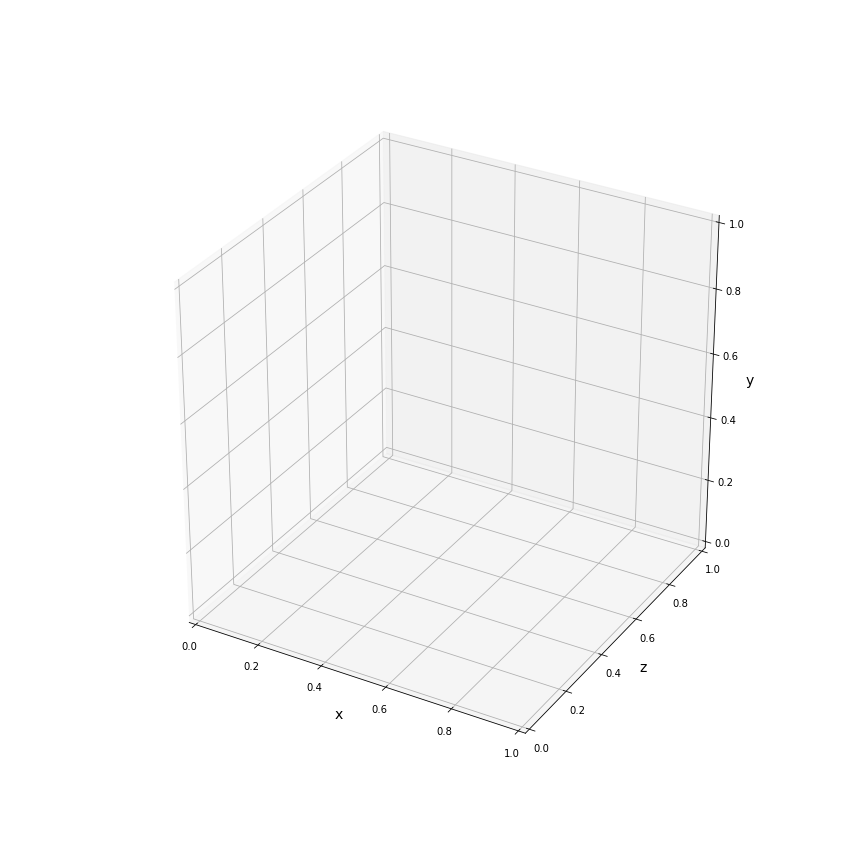

In [61]:
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

def plot_graph():
    for frag in curve_fragment:
        if frag.size == 0:
            continue
        #print(frag)
        x = frag[:,0]
        y = frag[:,1]
        z = frag[:,2]
        data = [x,y,z]
        
        try:
            if len(x)<2:
                continue
            tck, u = interpolate.splprep(data, k=3, s=1)
            new = interpolate.splev(u, tck, der=0)
            ax.plot(new[0], new[2], new[1],"-",c="#9FC963")
        except ValueError:
            pass
        except TypeError:
            pass
        
        
        #ax.plot(x, z, y,"-")
        
%matplotlib notebook
fig = plt.figure(figsize = (12, 12))
fig.patch.set_alpha(0.)
# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')

# 軸ラベルを設定
ax.set_xlabel("x", size = 14)
ax.set_ylabel("z", size = 14)
ax.set_zlabel("y", size = 14)
ax.set_box_aspect((1,1,1))
#ax.set_xticks(np.arange(-4,4,1))
#ax.set_yticks(np.arange(-4,4,1))
#ax.set_zticks(np.arange(-2,9,1))

plot_graph()

In [68]:
import pickle
with open("args.curves","wb") as f:
    pickle.dump(curve_fragment, f)
    